**Pneumonia type classification using Loss Calibration for BNN approach**

We are going to focus on three classes of images:

1. Normal: not pneumonia
2. Bacterial Pneumonia
3. Viral Pneumonia: not covid-19
4. Covid-19

We want to maximize the capacity of the model to predict correctly the covid-19 cases from images and avoid false negatives mostly for this class. Then we are going to proposse a utility function based on the paper idea in order to obtain good results for this task.

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.utils import to_categorical
import random


import sys
sys.path.insert(0, './code/')
sys.path.insert(0, './data/')
import lcbnn_multiclass as lcbnn
from utils import plot_confusion_matrix
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm



np.random.seed(seed=0)
random.seed(0)

Using TensorFlow backend.
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\felip\miniconda3\envs\vits

In [2]:
#paths
data = './data/'
covid_path = data + './data/COVID-19/' 
x_ray_path = data + './data/chest_xray/'

In [3]:
IMG_SIZE = 32

In [4]:
def read_images(images_paths):
    images = []
    for image_path in images_paths:
        image = cv2.imread(image_path)
        # resize image
        image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
        # transform to grayscale
        # image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        images.append(image)
    # reshape images to 1D array
    # images = np.array(images).reshape(-1,IMG_SIZE*IMG_SIZE)
    return np.array(images)

In [5]:
X_train = np.array([])
y_train = np.array([])
X_test = np.array([])
y_test = np.array([])
X_val = np.array([])
y_val = np.array([])

In [6]:
# read covid images
covid_images_paths = [covid_path + file_name for file_name in os.listdir(covid_path)]
covid_images = read_images(covid_images_paths)

In [7]:
covid_images.shape

(196, 32, 32, 3)

In [8]:
covid_train, covid_test = train_test_split(covid_images, test_size=0.2, random_state=42)
len(covid_train), len(covid_test)

(156, 40)

In [9]:
covid_test.shape

(40, 32, 32, 3)

In [10]:
# add covid images to train and test
X_train = covid_train
y_train = np.ones(len(covid_train))*3
X_test = covid_test
y_test = np.ones(len(covid_test))*3

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((156, 32, 32, 3), (156,), (40, 32, 32, 3), (40,))

In [12]:
# read normal images
normal_train_paths = [x_ray_path + 'train/NORMAL/' + file_name for file_name in os.listdir(x_ray_path + 'train/NORMAL/')]
normal_train = read_images(normal_train_paths)
normal_test_paths = [x_ray_path + 'test/NORMAL/' + file_name for file_name in os.listdir(x_ray_path + 'test/NORMAL/')]
normal_test = read_images(normal_test_paths)

In [13]:
# add normal images to train and test
X_train = np.concatenate((X_train, normal_train))
y_train = np.concatenate((y_train, np.zeros(len(normal_train))))
X_test = np.concatenate((X_test, normal_test))
y_test = np.concatenate((y_test, np.zeros(len(normal_test))))

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1505, 32, 32, 3), (1505,), (274, 32, 32, 3), (274,))

In [15]:
# read pneumonia images
pneumonia_train_paths = [x_ray_path + 'train/PNEUMONIA/' + file_name for file_name in os.listdir(x_ray_path + 'train/PNEUMONIA/')]
pneumonia_train = read_images(pneumonia_train_paths)
pneumonia_test_paths = [x_ray_path + 'test/PNEUMONIA/' + file_name for file_name in os.listdir(x_ray_path + 'test/PNEUMONIA/')]
pneumonia_test = read_images(pneumonia_test_paths)

In [16]:
# get labels for bacterial and viral pneumonia
pneumonia_train_labels = [1 if 'bacteria' in file_name else 2 for file_name in pneumonia_train_paths]
pneumonia_test_labels = [1 if 'bacteria' in file_name else 2 for file_name in pneumonia_test_paths]

In [17]:
# add pneumonia images to train and test
X_train = np.concatenate((X_train, pneumonia_train))
y_train = np.concatenate((y_train, pneumonia_train_labels))
X_test = np.concatenate((X_test, pneumonia_test))
y_test = np.concatenate((y_test, pneumonia_test_labels))

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5388, 32, 32, 3), (5388,), (664, 32, 32, 3), (664,))

In [19]:
# shuffle data
np.random.seed(42)
permutation = np.random.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]

permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation]
y_test = y_test[permutation]

c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  app.launch_new_instance()


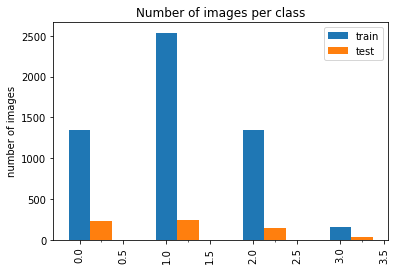

In [20]:
# plot the distribution of the classes on train and test
x = np.arange(4)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for l in ['train', 'test']:
    offset = width * multiplier
    v = [np.sum(y_train == i) if l == 'train' else np.sum(y_test == i) for i in range(4)]
    rects = ax.bar(x + offset, v, width, label=l)
    multiplier += 1

ax.set_ylabel('number of images')
ax.set_title('Number of images per class')
ax.set_xticks(x + width, ['Normal', 'Bacterial', 'Viral', 'COVID-19'])
ax.legend(loc='upper right')

plt.xticks(rotation=90)

plt.show()


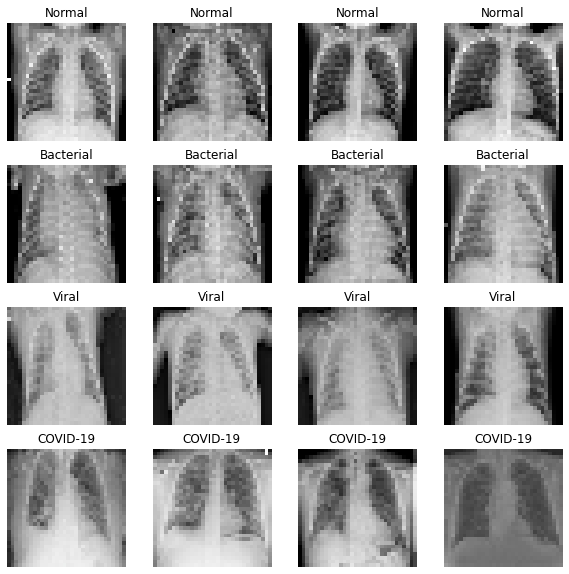

In [21]:
# visualize some images for each class
classes = ['Normal', 'Bacterial', 'Viral', 'COVID-19']
# classes = ['Normal', 'Bacterial', 'Viral', 'COVID-19']

fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(X_train[y_train == i][j])
        ax[i, j].set_title(classes[i])
        ax[i, j].axis('off')
plt.show()

In [40]:
# define the utility function for the problem
U = 1*np.eye(4)
U[0,1] = 0 # pred = normal, true = bacterial
U[0,2] = 0 # pred = normal, true = viral
U[0,3] = 0 # pred = normal, true = covid
U[1,0] = 0 # pred = bacterial, true = normal
U[1,2] = 0.1 # pred = bacterial, true = viral
U[1,3] = 0 # pred = bacterial, true = covid
U[2,0] = 0.1 # pred = viral, true = normal
U[2,1] = 0.3 # pred = viral, true = bacterial
U[2,3] = 0 # pred = viral, true = covid
U[3,0] = 0.1 # pred = covid, true = normal
U[3,1] = 0.4 # pred = covid, true = bacterial
U[3,2] = 0.7 # pred = covid, true = viral
U[3,3] = 1.3

# U = 2.1 - U
print(U)
U = 1.0001 - U
print(U)


[[1.  0.  0.  0. ]
 [0.  1.  0.1 0. ]
 [0.1 0.3 1.  0. ]
 [0.1 0.4 0.7 1.3]]
[[ 1.e-04  1.e+00  1.e+00  1.e+00]
 [ 1.e+00  1.e-04  9.e-01  1.e+00]
 [ 9.e-01  7.e-01  1.e-04  1.e+00]
 [ 9.e-01  6.e-01  3.e-01 -3.e-01]]


In [23]:
num_classes = 4
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training data classes count: {dict(zip(unique,counts))}")
unique, counts = np.unique(y_val, return_counts=True)
print(f"Training data classes count: {dict(zip(unique,counts))}")

Training data classes count: {0.0: 1079, 1.0: 2030, 2.0: 1076, 3.0: 125}
Training data classes count: {0.0: 270, 1.0: 508, 2.0: 269, 3.0: 31}


In [24]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [25]:
x_train = x_train/255
x_val = x_val/255
X_test = X_test/255

In [26]:
x_train = x_train.reshape(-1,IMG_SIZE*IMG_SIZE*3)
x_val = x_val.reshape(-1,IMG_SIZE*IMG_SIZE*3)
X_test = X_test.reshape(-1, IMG_SIZE*IMG_SIZE*3)

In [27]:
Early_Stop_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
# units
units = 80

dropout=0.2
# Regularise
tau = 1.0
lengthscale = .01
reg = lengthscale**2 * (1 - dropout) / (2. * len(x_train) * tau)

def network():
    model = Sequential()
    model.add(Dense(units, activation='relu', input_shape=x_train.shape[1:],W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(units, activation='relu',W_regularizer=l2(reg)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout)))
    model.add(Dense(num_classes, activation='softmax',W_regularizer=l2(reg)))
    return model

STD

In [28]:
epochs = 30
batch_size = 16
std_model = network()
std_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_std = std_model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=[x_val,y_val],
                  )

c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", input_shape=(3072,), kernel_regularizer=<keras.reg...)`
  del sys.path[0]
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_regularizer=<keras.reg...)`


Train on 4310 samples, validate on 1078 samples
Epoch 1/30
4310/4310 [==============================] - 1s 223us/step - loss: 1.0644 - acc: 0.4988 - val_loss: 0.8832 - val_acc: 0.6104
Epoch 2/30
4310/4310 [==============================] - 1s 162us/step - loss: 0.8613 - acc: 0.6278 - val_loss: 0.8394 - val_acc: 0.6308
Epoch 3/30
4310/4310 [==============================] - 1s 177us/step - loss: 0.8238 - acc: 0.6367 - val_loss: 0.8427 - val_acc: 0.6336
Epoch 4/30
4310/4310 [==============================] - 1s 181us/step - loss: 0.8246 - acc: 0.6369 - val_loss: 0.8558 - val_acc: 0.6308
Epoch 5/30
4310/4310 [==============================] - 1s 177us/step - loss: 0.8157 - acc: 0.6418 - val_loss: 0.9293 - val_acc: 0.6011
Epoch 6/30
4310/4310 [==============================] - 1s 185us/step - loss: 0.7993 - acc: 0.6490 - val_loss: 0.8180 - val_acc: 0.6419
Epoch 7/30
4310/4310 [==============================] - 1s 173us/step - loss: 0.7859 - acc: 0.6508 - val_loss: 0.8738 - val_acc: 0.6141


WEIGHTED

In [29]:
# Set up weight for weighted cross entropy
# goal_class = [3]
class_weight = np.ones((num_classes))
class_weight[0] = 1.3
class_weight[2] = 1.3
class_weight[3] = 1.5


In [30]:
we_model = network()
we_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

history_we = we_model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=30,
                  verbose=1,
                  validation_data=[x_val,y_val],
                  class_weight = class_weight, 
                  )


c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", input_shape=(3072,), kernel_regularizer=<keras.reg...)`
  del sys.path[0]
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_regularizer=<keras.reg...)`


Train on 4310 samples, validate on 1078 samples
Epoch 1/30
4310/4310 [==============================] - 1s 250us/step - loss: 1.0434 - acc: 0.5323 - val_loss: 0.8402 - val_acc: 0.6494
Epoch 2/30
4310/4310 [==============================] - 1s 196us/step - loss: 0.8433 - acc: 0.6341 - val_loss: 0.7831 - val_acc: 0.6549
Epoch 3/30
4310/4310 [==============================] - 1s 221us/step - loss: 0.7556 - acc: 0.6710 - val_loss: 0.7572 - val_acc: 0.6688
Epoch 4/30
4310/4310 [==============================] - 1s 189us/step - loss: 0.7184 - acc: 0.6789 - val_loss: 0.7392 - val_acc: 0.6800
Epoch 5/30
4310/4310 [==============================] - 1s 211us/step - loss: 0.7229 - acc: 0.6724 - val_loss: 0.7484 - val_acc: 0.6679
Epoch 6/30
4310/4310 [==============================] - 1s 203us/step - loss: 0.6924 - acc: 0.6840 - val_loss: 0.7062 - val_acc: 0.6902
Epoch 7/30
4310/4310 [==============================] - 1s 211us/step - loss: 0.7062 - acc: 0.6810 - val_loss: 0.7651 - val_acc: 0.6633


LOSS CALIBRATED

In [36]:
M = 1.0001
basic_model = network()
# Initilise loss
decision_loss = lcbnn.loss_K(U)

H_x = Input(shape=(num_classes,),name='H_x')
y_true = Input(shape=(num_classes,),name='y_true')
x = Input(shape=(x_train.shape[1:]),name='x')

y_pred = basic_model(x)

lc_model = Model([x,H_x],y_pred)
lc_model.compile(loss = lcbnn.cal_loss(decision_loss,M,H_x),optimizer='adam')

#Initiailisations:
y_pred_samples = np.expand_dims(y_train,0)
y_pred_samples_val = np.expand_dims(y_val,0)
H_x = lcbnn.optimal_h(y_pred_samples,U) #np.random.randint(0,2,(np.shape(y_train)))
H_x_val = lcbnn.optimal_h(y_pred_samples_val,U)

history_lc = []
for epoch in range(30):
    h_lc = lc_model.fit([x_train,H_x],[y_train],
                 batch_size=batch_size,
                 nb_epoch=1,
                 verbose=1,
                 validation_data=[[x_val,H_x_val],y_val],
                 )
    T = 10
    yt_hat = np.array([lc_model.predict([x_train,H_x]) for _ in range(T)])
    H_x = lcbnn.optimal_h(yt_hat,U)
    history_lc.append(h_lc)

c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", input_shape=(3072,), kernel_regularizer=<keras.reg...)`
  del sys.path[0]
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
  from ipykernel import kernelapp as app
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(80, activation="relu", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="softmax", kernel_regularizer=<keras.reg...)`
c:\Users\felip\miniconda3\envs\vits-pip\lib\site-packages\ipykernel_launcher.py:27: UserWa

Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 269us/step - loss: 1.7817 - val_loss: 1.6384
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 221us/step - loss: 1.3470 - val_loss: 1.4152
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 207us/step - loss: 1.1764 - val_loss: 1.3074
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 232us/step - loss: 1.1093 - val_loss: 1.2998
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 198us/step - loss: 1.1097 - val_loss: 1.2671
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [==============================] - 1s 204us/step - loss: 1.0815 - val_loss: 1.3070
Train on 4310 samples, validate on 1078 samples
Epoch 1/1
4310/4310 [=========================

RESULTS

In [37]:
T = 100
loss_mat = U
H_x_test = np.zeros_like(y_test)

#######
# STD #
#######
yt_hat_std = np.array([std_model.predict([X_test]) for _ in range(T)])
MC_pred_std = np.mean(yt_hat_std, 0)
H_x_test_std = lcbnn.optimal_h(yt_hat_std,loss_mat) 
acc_std = accuracy_score(np.argmax(y_test,1),np.argmax(H_x_test_std,1))
loss_std = np.mean(lcbnn.loss_np(y_test,H_x_test_std,loss_mat))
print('Standard:\n')
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)

#######
# WEI #
#######
yt_hat_we = np.array([we_model.predict([X_test]) for _ in range(T)])
MC_pred_we = np.mean(yt_hat_we, 0)
H_x_test_we = lcbnn.optimal_h(yt_hat_we,loss_mat) 
acc_we = accuracy_score(np.argmax(y_test,1),np.argmax(H_x_test_we,1))
loss_we = np.mean(lcbnn.loss_np(y_test,H_x_test_we,loss_mat))

print('\nWeighted:\n')
print('Accuracy on optimal decision: ', acc_we)
print('Expected loss: ', loss_we)

#######
# L-C #
#######
yt_hat_lc = np.array([lc_model.predict([X_test, H_x_test]) for _ in range(T)])
MC_pred_lc = np.mean(yt_hat_lc, 0)
H_x_test_lc = lcbnn.optimal_h(yt_hat_lc,loss_mat) 
acc_lc = accuracy_score(np.argmax(y_test,1),np.argmax(H_x_test_lc,1))
loss_lc = np.mean(lcbnn.loss_np(y_test,H_x_test_lc,loss_mat))
print('\nLoss-cal:\n')
print('Accuracy on optimal decision: ', acc_lc)
print('Expected loss: ', loss_lc)


Standard:

Accuracy on optimal decision:  0.625
Expected loss:  0.3290156626506024

Weighted:

Accuracy on optimal decision:  0.677710843373494
Expected loss:  0.2582325301204819

Loss-cal:

Accuracy on optimal decision:  0.6822289156626506
Expected loss:  0.2690759036144578


CONFUSION MATRICES

Normalized confusion matrix
[[0.48 0.25 0.2  0.07]
 [0.01 0.93 0.04 0.02]
 [0.08 0.48 0.39 0.05]
 [0.03 0.42 0.   0.55]]
Normalized confusion matrix
[[0.44 0.01 0.43 0.13]
 [0.   0.77 0.22 0.  ]
 [0.05 0.1  0.84 0.01]
 [0.03 0.03 0.03 0.93]]
Normalized confusion matrix
[[0.41 0.09 0.38 0.12]
 [0.   0.94 0.06 0.  ]
 [0.05 0.26 0.66 0.03]
 [0.03 0.15 0.   0.82]]


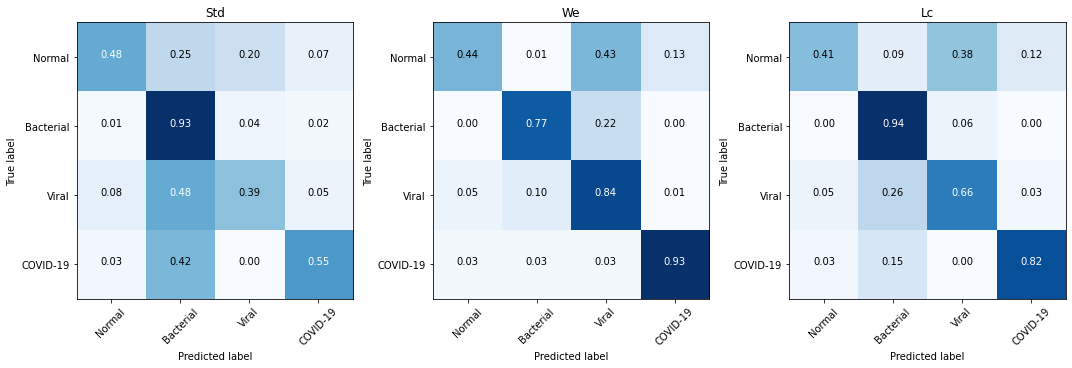

In [38]:
plt.rcParams['figure.figsize'] = (15, 15)

H_std = np.argmax(H_x_test_std, axis=1)
H_we = np.argmax(H_x_test_we, axis=1)
H_lc = np.argmax(H_x_test_lc, axis=1)

Y = np.argmax(y_test, axis=1)
cnf_matrix_std = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_std.reshape((H_x_test.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_we = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_we.reshape((H_x_test.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_lc = confusion_matrix(Y.reshape((y_test.shape[0],)).astype('float'),np.round(H_lc.reshape((H_x_test.shape[0],))))
np.set_printoptions(precision=2)

plt.subplot(131)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_std, classes=classes, normalize=True,
                      title='Std')

plt.subplot(132)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_we, classes=classes, normalize=True,
                      title='We')

plt.subplot(133)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_lc, classes=classes, normalize=True,
                      title='Lc')
plt.show()

TRAINING STATISTICS

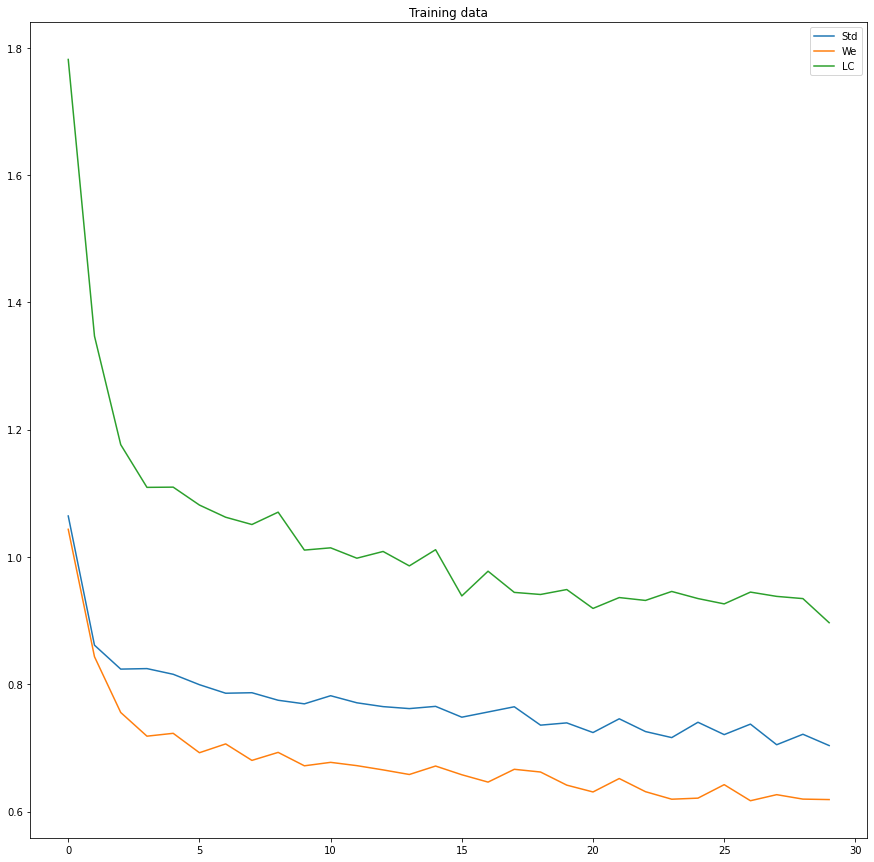

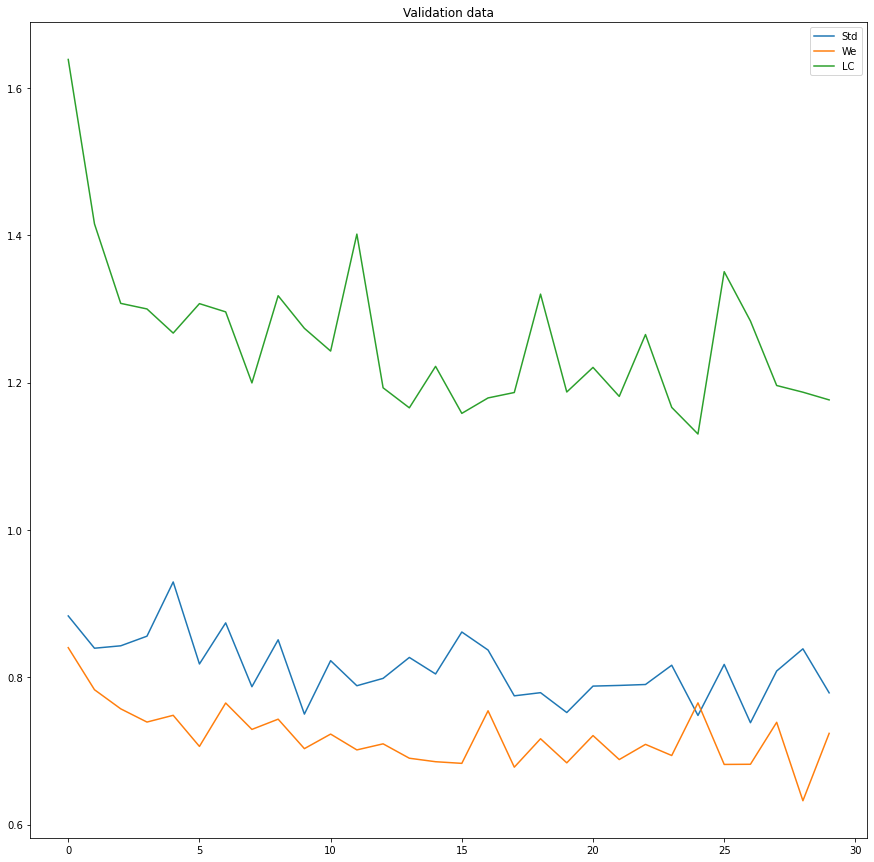

In [39]:
h = []
h_val = []
for i in range(epochs):
    h.append(history_lc[i].history['loss'])
    h_val.append(history_lc[i].history['val_loss'])
    
plt.figure()
plt.title('Training data')
plt.plot(history_std.history['loss'], label='Std')
plt.plot(history_we.history['loss'], label='We')
plt.plot(h,label='LC')
plt.legend()
plt.show()

plt.figure()
plt.title('Validation data')
plt.plot(history_std.history['val_loss'], label='Std')
plt.plot(history_we.history['val_loss'], label='We')
plt.plot(h_val,label='LC')
plt.legend()
plt.show()